Матрица линейного преобразования T:
[[ 2.         -0.          7.        ]
 [ 1.15470054  2.          8.15470054]
 [ 0.          0.          1.        ]]

Коэффициенты линейного преобразования:
T(u,v) = (2.0000u + -0.0000v + 7.0000, 1.1547u + 2.0000v + 8.1547)

Проверка преобразования:
T(K) = [5. 5.], должно быть A = [5 5]
T(L) = [9.         7.30940108], должно быть B = [9.         7.30940108]
T(M) = [ 9.         11.30940108], должно быть C = [ 9.         11.30940108]
T(N) = [5. 9.], должно быть D = [5 9]

Ошибка для точки N: 0.0000000000


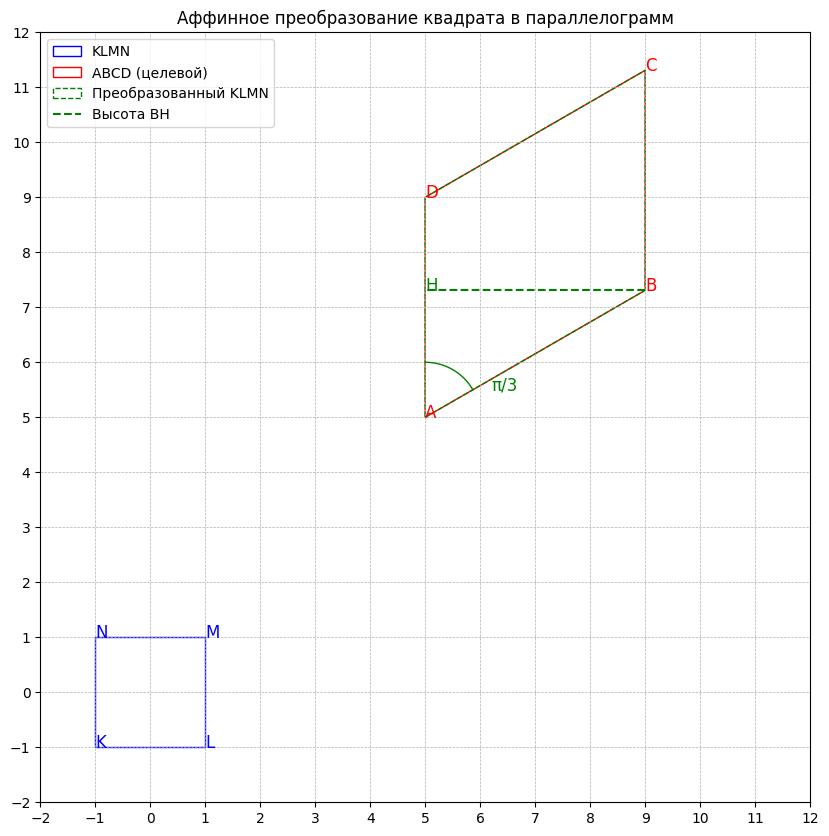


Разложение на элементарные преобразования:
1. Перенос K в начало координат (P1)
[[1 0 1]
 [0 1 1]
 [0 0 1]]

2. Линейное преобразование (поворот + масштабирование)
Линейная часть:
[[ 2.         -0.        ]
 [ 1.15470054  2.        ]]

3. Финальный сдвиг (P3)
[[1. 0. 5.]
 [0. 1. 5.]
 [0. 0. 1.]]

Проверка композиции элементарных преобразований:
T_decomposed =
[[2.         0.         7.        ]
 [1.15470054 2.         8.15470054]
 [0.         0.         1.        ]]

Исходная матрица T =
[[ 2.         -0.          7.        ]
 [ 1.15470054  2.          8.15470054]
 [ 0.          0.          1.        ]]

Разность T - T_decomposed =
[[ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# ----- Исходный квадрат KLMN -----
# K=(-1,-1), L=(1,-1), M=(1,1), N=(-1,1)
K = np.array([-1, -1])
L = np.array([1, -1])
M = np.array([1, 1])
N = np.array([-1, 1])
square = np.vstack([K, L, M, N])

# ----- Определение параметров параллелограмма ABCD -----
# 1. Вершина A лежит на луче KM и в 3 раза дальше от K, чем M
A = K + 3 * (M - K)  # A = (-1,-1) + 3*(2,2) = (5,5)

# 2. Образ стороны KN (AD) параллелен KN и его длина в 2 раза больше KN
# KN = (-1,1) - (-1,-1) = (0,2)
# AD = 2*KN = (0,4)
D = A + 2 * (N - K)  # D = (5,5) + 2*(0,2) = (5,9)

# 3. Угол параллелограмма при вершине A равен π/3
# Сейчас вектор AD = (0,4) вертикальный
# Для угла pi/3 между B и AD, вектор AB должен иметь направление p/6 от оси X
angle_AB = np.pi/6
dir_AB = np.array([np.cos(angle_AB), np.sin(angle_AB)])

# 4. Высота параллелограмма BH, H ∈ AD, равна двум сторонам квадрата
# Высота = |AB| * sin(pi/3)
# Сторона квадрата = 2, значит высота = 4
# |AB| * sin(pi/3) = 4
# |AB| = 4 / sin(pi/3) = 4 / (sqrt(3)/2) = 8/sqrt(3)
length_AB = 4 / np.sin(np.pi/3)
AB = length_AB * dir_AB  # (8/sqrt(3)) * (cos pi/6, sin pi/6)

# Вычисляем B и C
B = A + AB
C = B + (D - A)  # Чтобы параллелограмм замкнулся

# Собираем вершины параллелограмма ABCD
ABCD = np.vstack([A, B, C, D])

# ----- Нахождение линейного преобразования T(u,v) = (au+bv+e, cu+dv+f) -----
# T(K) = A  ->  T(-1,-1) = (5,5)
# T(L) = B  ->  T(1,-1) = B
# T(M) = C  ->  T(1,1) = C
# T(N) = D  ->  T(-1,1) = (5,9)

# Для определения линейного преобразования достаточно знать преобразование трех точек
# Мы используем точки K, L и M, чтобы найти преобразование

# Для аффинного преобразования T(x,y) = (ax + by + e, cx + dy + f)
# T(K) = A  ->  a*(-1) + b*(-1) + e = A[0],  c*(-1) + d*(-1) + f = A[1]
# T(L) = B  ->  a*(1) + b*(-1) + e = B[0],   c*(1) + d*(-1) + f = B[1]
# T(M) = C  ->  a*(1) + b*(1) + e = C[0],    c*(1) + d*(1) + f = C[1]

# Составим матрицу уравнений для (a,b,e)
A_x = np.array([
    [-1, -1, 1],
    [1, -1, 1],
    [1, 1, 1]
])

# Правые части для x и y координат
b_x = np.array([A[0], B[0], C[0]])
b_y = np.array([A[1], B[1], C[1]])

# Решаем системы уравнений
a, b, e = np.linalg.solve(A_x, b_x)
c, d, f = np.linalg.solve(A_x, b_y)

# Формируем матрицу преобразования в однородных координатах
T = np.array([
    [a, b, e],
    [c, d, f],
    [0, 0, 1]
])

print("Матрица линейного преобразования T:")
print(T)
print("\nКоэффициенты линейного преобразования:")
print(f"T(u,v) = ({a:.4f}u + {b:.4f}v + {e:.4f}, {c:.4f}u + {d:.4f}v + {f:.4f})")

# ----- Проверка преобразования -----
def transform_point(point, matrix):
    homog = np.append(point, 1)  # Однородные координаты
    result = homog @ matrix.T
    return result[:2]  # Возвращаем только x,y

# Применяем преобразование ко всем вершинам квадрата
transformed_K = transform_point(K, T)
transformed_L = transform_point(L, T)
transformed_M = transform_point(M, T)
transformed_N = transform_point(N, T)
transformed_square = np.vstack([transformed_K, transformed_L, transformed_M, transformed_N])

print("\nПроверка преобразования:")
print(f"T(K) = {transformed_K}, должно быть A = {A}")
print(f"T(L) = {transformed_L}, должно быть B = {B}")
print(f"T(M) = {transformed_M}, должно быть C = {C}")
print(f"T(N) = {transformed_N}, должно быть D = {D}")

# Проверяем точку N, которая не участвовала в определении преобразования
point_error = np.linalg.norm(transformed_N - D)
print(f"\nОшибка для точки N: {point_error:.10f}")

# ----- Визуализация -----
fig, ax = plt.subplots(figsize=(10, 10))

# Рисуем исходный квадрат
square_poly = Polygon(square, closed=True, fill=False, edgecolor='blue', label='KLMN')
ax.add_patch(square_poly)
for point, label in zip(square, ['K', 'L', 'M', 'N']):
    ax.text(point[0], point[1], label, fontsize=12, color='blue')

# Рисуем параллелограмм (целевой)
parallelogram_poly = Polygon(ABCD, closed=True, fill=False, edgecolor='red', label='ABCD (целевой)')
ax.add_patch(parallelogram_poly)
for point, label in zip(ABCD, ['A', 'B', 'C', 'D']):
    ax.text(point[0], point[1], label, fontsize=12, color='red')

# Рисуем преобразованный квадрат
transformed_poly = Polygon(transformed_square, closed=True, fill=False, edgecolor='green', 
                         linestyle='--', label='Преобразованный KLMN')
ax.add_patch(transformed_poly)

# Добавляем высоту BH для демонстрации
# Находим точку H на AD
H_param = np.dot(B - A, D - A) / np.dot(D - A, D - A)
H = A + H_param * (D - A)
ax.plot([B[0], H[0]], [B[1], H[1]], 'g--', label='Высота BH')
ax.text(H[0], H[1], 'H', fontsize=12, color='green')

# Добавляем демонстрацию угла pi/3
angle_arc_r = 1.0
arc_points = 50
angle_theta = np.linspace(0, np.pi/3, arc_points)
arc_x = A[0] + angle_arc_r * np.cos(angle_theta + np.pi/2 - np.pi/3)
arc_y = A[1] + angle_arc_r * np.sin(angle_theta + np.pi/2 - np.pi/3)
ax.plot(arc_x, arc_y, 'g-', linewidth=1)
ax.text(A[0] + 1.2, A[1] + 0.5, 'π/3', fontsize=12, color='green')

# Настраиваем сетку с шагом 1
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.set_xticks(np.arange(-2, 13, 1))  
ax.set_yticks(np.arange(-2, 13, 1))  
ax.set_aspect('equal')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  
ax.legend()
ax.set_title('Аффинное преобразование квадрата в параллелограмм')
plt.show()

# ----- Представление в виде элементарных преобразований -----
# Теперь выразим преобразование как комбинацию элементарных преобразований
# T(u,v) = (au+bv+e, cu+dv+f)

# Разложение:
# 1. Перенос квадрата так, чтобы K оказался в начале координат: P1(x,y) = (x+1, y+1)
P1 = np.array([
    [1, 0, 1],
    [0, 1, 1],
    [0, 0, 1]
])

# 2. Матрица линейного преобразования без учета сдвига
# Это преобразует единичный квадрат с вершиной в начале координат
M_linear = np.array([
    [a, b],
    [c, d]
])

# 3. Сдвиг в итоговую позицию
offset = np.array([e, f]) - np.dot(M_linear, np.array([1, 1]))
P3 = np.array([
    [1, 0, offset[0]],
    [0, 1, offset[1]],
    [0, 0, 1]
])

print("\nРазложение на элементарные преобразования:")
print("1. Перенос K в начало координат (P1)")
print(P1)
print("\n2. Линейное преобразование")
print(f"Линейная часть:\n{M_linear}")
print(f"\n3. Финальный сдвиг (P3)")
print(P3)

# Проверим, что композиция этих преобразований даёт исходное преобразование T
M_linear_homog = np.eye(3)
M_linear_homog[:2, :2] = M_linear

T_decomposed = P3 @ M_linear_homog @ P1
print("\nПроверка композиции элементарных преобразований:")
print("T_decomposed =")
print(T_decomposed)
print("\nИсходная матрица T =")
print(T)
print("\nРазность T - T_decomposed =")
print(T - T_decomposed)